In [1]:
import xtrack as xt
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
line = xt.Line.from_json('injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
tt = line.get_table(attr=True)

In [4]:
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

In [ ]:
# for name in line.element_names:
#     if 'Sextupole' in line[name].__class__.__name__ and 'drift' not in name:
#         if hasattr(line[name]._parent, 'k2'):
#             line[name]._parent.k2 = 0.0
#             line[name]._parent.k2s = 0.0
#             line[name]._parent.k2l = 0.0
#             line[name]._parent.k2sl = 0.0
#     elif 'Octupole' in line[name].__class__.__name__ and 'drift' not in name:
#         if hasattr(line[name]._parent, 'k3'):
#             line[name]._parent.k3 = 0.0
#             line[name]._parent.k3s = 0.0
#             line[name]._parent.k3l = 0.0
#             line[name]._parent.k3sl = 0.0
#     elif 'Multipole' in line[name].__class__.__name__ and 'drift' not in name:
#         if hasattr(line[name], 'knl'):
#             line[name].kn = np.array([0.0])
#             line[name].knl = np.array([0.0])
#             line[name].knsl = np.array([0.0])
#             line[name].kns = np.array([0.0])
#     elif 'Cavity' in line[name].__class__.__name__:
#         if hasattr(line[name], 'voltage'):
#             line[name].voltage = 0.0
#Method not enough to turn off all multipoles and cavities

In [6]:
for name in line.element_names:
    if 'Cavity' in line[name].__class__.__name__:
        if hasattr(line[name], 'voltage'):
            line[name].voltage = 0.0

In [7]:
tt_vars = line.vars.get_table()
for kk in tt_vars.rows['kls.*'].name:
    line[kk] = 0.0

for kk in tt_vars.rows['kl.*'].name:
    line[kk] = 0.0
for kk in tt_vars.rows['ks.*'].name:
    line[kk] = 0.0

In [8]:
num_turns = 1000
num_particles = 1000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [9]:
#Check aperture
df_with_coll = line.check_aperture()

#OPtimize line and optics
line.build_tracker()
tw = line.twiss(method='4d')
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
line.optimize_for_tracking()

Checking aperture:   0%|          | 0/30210 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
The line already has an associated tracker
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data


In [10]:
x_int = np.linspace(-12.7, 12.7, round(12.7*2/0.1)+1)
x_ext = np.linspace(-14.7, 14.7, round(14.7*2/0.1)+1)

y_int = np.linspace(-4.6683, 4.6683, round(4.6683*2/0.1)+1)
y_ext = np.linspace(-6.6683, 6.6683, round(6.6683*2/0.1)+1)

X, Y = np.meshgrid(x_ext, y_ext, indexing='xy')

x_flat = X.ravel()
y_flat = Y.ravel()

# Filter out points that fall inside the inner rectangle
mask = ~((x_flat >= x_int.min()) & (x_flat <= x_int.max()) &
         (y_flat >= y_int.min()) & (y_flat <= y_int.max()))

# Apply mask
x_hollow = x_flat[mask]
y_hollow = y_flat[mask]
x_norm = x_hollow
y_norm = y_hollow
px_norm = np.zeros_like(x_norm)
py_norm = np.zeros_like(x_norm)
zeta = np.zeros_like(x_norm)
delta = np.zeros_like(x_norm)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, method='4d')#, zeta=zeta, delta=delta)
part2 = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, method='4d')#, zeta=zeta, delta=delta)

Text(0, 0.5, 'y_norm [sigma]')

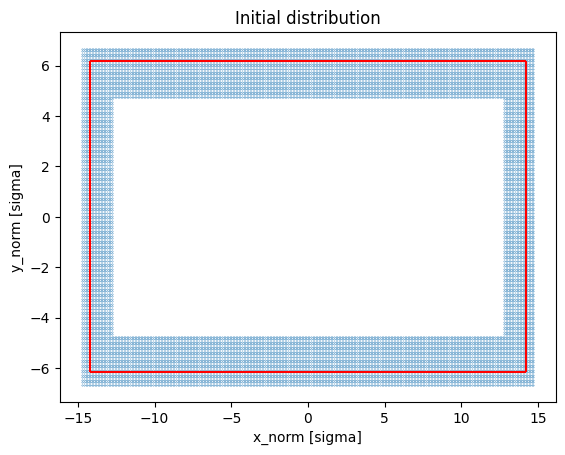

In [11]:
plt.figure()
plt.plot(
    x_hollow,
    y_hollow,
    marker='.',
    linestyle='None',
    markersize=0.5,
)
plt.vlines(-14.2, -6.1683, 6.1683, color='r')
plt.vlines(14.2, -6.1683, 6.1683, color='r')
plt.hlines(-6.1683, -14.2, 14.2, color='r')
plt.hlines(6.1683, -14.2, 14.2, color='r')
plt.title('Initial distribution')
plt.xlabel('x_norm [sigma]')
plt.ylabel('y_norm [sigma]')

In [12]:
monitor = xt.ParticlesMonitor(_context=line._context,
    num_particles=len(part.x),
    start_at_turn=0, # <-- first turn to monitor (including)
    stop_at_turn=num_turns, # <-- last turn to monitor (excluding)
)


line.discard_tracker()
line.insert_element(
    name="monitor", 
    element=monitor, 
    at=1
)
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [13]:
# Track!
#line.discard_tracker()
#line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=1, freeze_longitudinal=True)
line.scattering.disable()

No xcoll elements found in line.


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
No xcoll elements found in line.


In [14]:
particles = part.to_dict()

In [15]:
idxs, death_turns, states = zip(*sorted(zip(particles['particle_id'], particles['at_turn'], particles['state'])))
idxs = np.array(idxs)
death_turns = np.array(death_turns)
states = np.array(states)

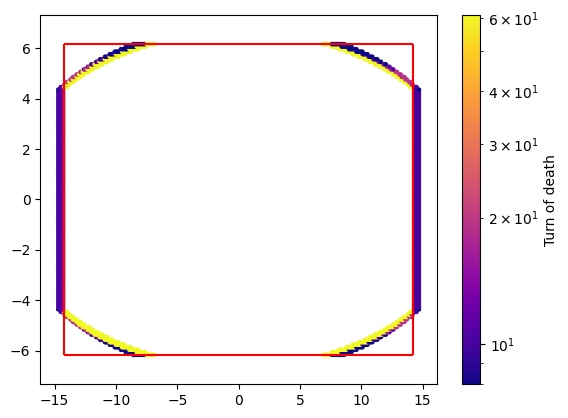

In [16]:
plt.figure()
m = (states <=0) #& (death_turns > 100)
alive = (states > 0)
sc = plt.scatter(x_hollow[m], y_hollow[m], c=death_turns[m], cmap='plasma', norm=colors.LogNorm(), marker='o', s=5)
cbar = plt.colorbar(sc)
cbar.set_label("Turn of death")
#plt.scatter(x_hollow[alive], y_hollow[alive], c='green', marker='o', s=5)
plt.hlines(6.1683, -14.2, 14.2, color='red')
plt.hlines(-6.1683, -14.2, 14.2, color='red')
plt.vlines(14.2, -6.1683, 6.1683, color='red')
plt.vlines(-14.2, -6.1683, 6.1683, color='red')

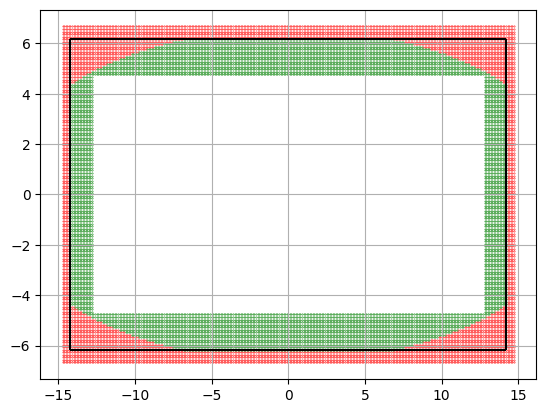

In [17]:
plt.figure()
alive = (states > 0)
plt.scatter(x_hollow[~alive], y_hollow[~alive], c='red', marker='o', s=0.1)
plt.scatter(x_hollow[alive], y_hollow[alive], c='green', marker='o', s=0.1)
plt.hlines(6.1683, -14.2, 14.2, color='black')
plt.hlines(-6.1683, -14.2, 14.2, color='black')
plt.vlines(14.2, -6.1683, 6.1683, color='black')
plt.vlines(-14.2, -6.1683, 6.1683, color='black')
plt.grid()

In [18]:
def find_scaling_factor(gamma, alpha, beta, x, px):
    return gamma * x**2 + 2 * alpha * x * px + beta * px**2


def parametric_ellipse(gamma, alpha, beta, scaling, num_points=300):
    # Step 1: Compute eigenvalues (semi-axes squared)
    lambda_1 = (gamma + beta + np.sqrt((gamma - beta)**2 + 4 * alpha**2)) / 2
    lambda_2 = (gamma + beta - np.sqrt((gamma - beta)**2 + 4 * alpha**2)) / 2

    # Step 2: Compute rotation angle
    phi = 0.5 * np.arctan2(2 * alpha, gamma - beta) + np.pi / 2

    # Step 3: Parametric angle
    theta = np.linspace(0, 2 * np.pi, num_points)

    # Step 4: Scale eigenvalues by sigma * epsilon and apply y-axis symmetry
    scaling_factor = np.sqrt(scaling)
    x = -scaling_factor * (np.sqrt(lambda_1) * np.cos(theta) * np.cos(phi) + np.sqrt(lambda_2) * np.sin(theta) * np.sin(phi))
    p_x = scaling_factor * (-np.sqrt(lambda_1) * np.cos(theta) * np.sin(phi) + np.sqrt(lambda_2) * np.sin(theta) * np.cos(phi))


    
    # Plot the ellipse
    #plt.plot(x, p_x, color='red')
    #plt.xlabel("x")
    #plt.ylabel("p_x")
    #plt.gca().set_aspect('equal')
    #plt.grid(True)
    #plt.title("Parametric Ellipse")
    #plt.show()
    return x, p_x

# Example usage
#parametric_ellipse(gamma=4, alpha=1, beta=3, scaling=2)

/tmp/lpauwels/ipykernel_3585072/3361705214.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter = plt.scatter(


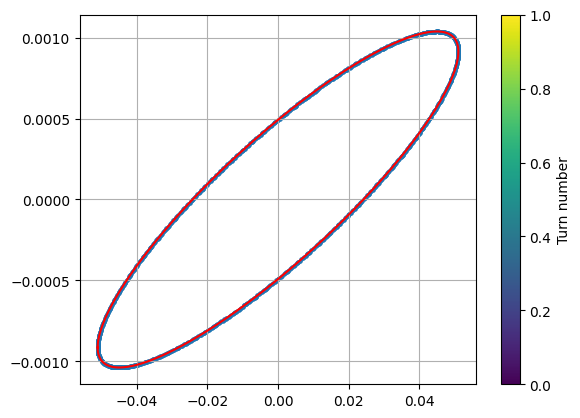

In [19]:
particle_id = 9133
plt.figure()
scatter = plt.scatter(
    monitor.x[particle_id, :num_turns],
    monitor.px[particle_id, :num_turns],
    cmap='turbo',#'plasma', 
    norm=colors.LogNorm(vmin=1, vmax=num_turns), 
    s=5  # Size of points
)
plt.colorbar(label="Turn number")

x_ell, px_ell = parametric_ellipse(
    gamma=tw.gamx[2], 
    alpha=tw.alfx[2], 
    beta=tw.betx[2], 
    scaling=find_scaling_factor(tw.gamx[2], tw.alfx[2], tw.betx[2], part2.x[particle_id], part2.px[particle_id]), 
    num_points=1000
)
plt.plot(x_ell, px_ell, color='red')
plt.grid()
plt.show()

In [20]:
living_idxs = part.particle_id[part.state>0]

lx = []
ly = []
for idx in living_idxs:
    lx.append(part2.x[idx])
    ly.append(part2.y[idx])
mx, my = np.max(lx), np.max(ly)
idx_mx = living_idxs[np.argmax(lx)]
idx_my = living_idxs[np.argmax(ly)]

new_idx_mx = np.where(part.particle_id == idx_mx)[0][0]
new_idx_my = np.where(part.particle_id == idx_my)[0][0]

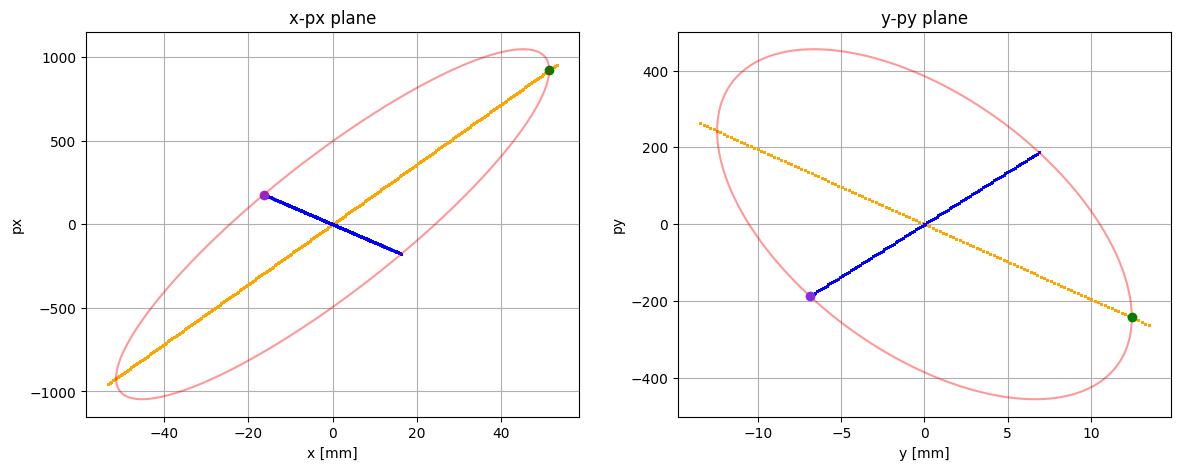

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(monitor.x[:, 0] * 1e3, monitor.px[:, 0] * 1e6, marker='.', markersize=1, linestyle='None', color = 'orange')
ax[0].plot(monitor.x[:, 999] * 1e3, monitor.px[:, 999] * 1e6, marker='.', markersize=1, linestyle='None', color = 'blue')
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('px')
ax[0].grid()
ax[0].set_title('x-px plane')
x_ell, px_ell = parametric_ellipse(
    gamma=tw.gamx[2], 
    alpha=tw.alfx[2], 
    beta=tw.betx[2], 
    scaling=find_scaling_factor(tw.gamx[2], tw.alfx[2], tw.betx[2], part2.x[idx_mx], part2.px[idx_mx]), 
    num_points=1000
)
ax[0].plot(part2.x[idx_mx]*1e3, part2.px[idx_mx]*1e6, 'go')
ax[0].plot(monitor.x[idx_mx, 999]*1e3, monitor.px[idx_mx, 999]*1e6, marker = 'o', color = 'blueviolet')
ax[0].plot(x_ell * 1e3, px_ell * 1e6, color='red', alpha=0.4)

ax[1].plot(monitor.y[:, 0] * 1e3, monitor.py[:, 0] * 1e6, marker='.', markersize=1, linestyle='None', color = 'orange')
ax[1].plot(monitor.y[:, 999] * 1e3, monitor.py[:, 999] * 1e6, marker='.', markersize=1, linestyle='None', color = 'blue')
ax[1].set_xlabel('y [mm]')
ax[1].set_ylabel('py')
ax[1].grid()
ax[1].set_title('y-py plane')
y_ell, py_ell = parametric_ellipse(
    gamma=tw.gamy[2], 
    alpha=tw.alfy[2], 
    beta=tw.bety[2], 
    scaling=find_scaling_factor(tw.gamy[2], tw.alfy[2], tw.bety[2], part2.y[idx_my], part2.py[idx_my]), 
    num_points=1000
)
ax[1].plot(y_ell * 1e3, py_ell * 1e6, color='red', alpha=0.4)
ax[1].plot(part2.y[idx_my]*1e3, part2.py[idx_my]*1e6, 'go')
ax[1].plot(monitor.y[idx_my, 999]*1e3, monitor.py[idx_my, 999]*1e6, marker = 'o', color = 'blueviolet') # it has to be monitor and not part to have the final position

In [34]:
part.y

array([-0.01193603, -0.01193603, -0.01193603, ..., -0.01855413,
       -0.01855413, -0.01855413])